In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import os
from tqdm import tqdm
import math
import requests, lxml, re, json
import pickle
from umap import UMAP
import plotly.express as px
from grb.light_curves import *
from grb.furie import *
from grb.time import *
from grb.config import DATA_PATH, logging
from grb.utils import Chi2_polyval
from grb.blind_search import process_time_window, filter_missing_data_and_flares,recursive_event_search

In [2]:
ztf_search_conditions = {x:{
    'n_bins':29,
    'sigma_threshold':3,
    'chi_2_limit':3
    } for x in range(5,121,5)}

In [3]:
r = requests.get(f"https://193.232.11.95/lvc/r//AT2023avj/8421.35080074074_8421.86422666667__5s/acs_T5.dat",verify=False,stream=True)
with open(f"data/acs_T5.dat", 'wb') as f:
            f.write(r.raw.read())

c:\Users\georg\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host '193.232.11.95'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


In [4]:
ACS_lc = SPI_ACS_LightCurve('2023-01-21 20:04:07',500,data = np.loadtxt(f'{DATA_PATH}acs_T5.dat'))
ACS_lc.original_times = (ACS_lc.times - get_ijd_from_utc(ACS_lc.event_time))*(24*60*60)
ACS_lc.original_resolution = np.mean(np.diff(ACS_lc.original_times))

  0%|          | 0/9220 [00:00<?, ?it/s]

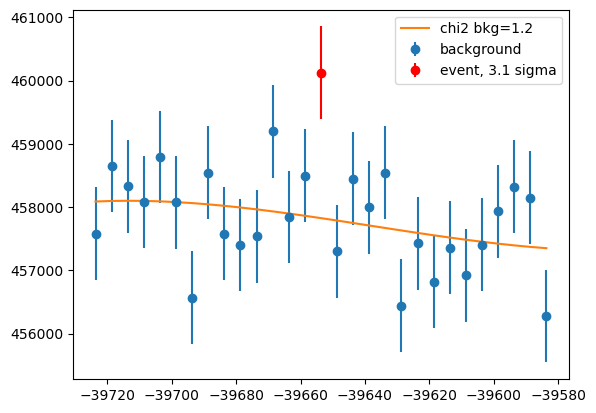

  6%|▌         | 560/9220 [00:00<00:03, 2524.84it/s]

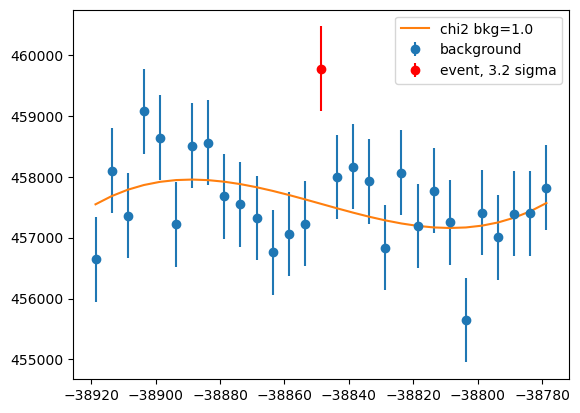

  9%|▉         | 813/9220 [00:00<00:03, 2518.40it/s]

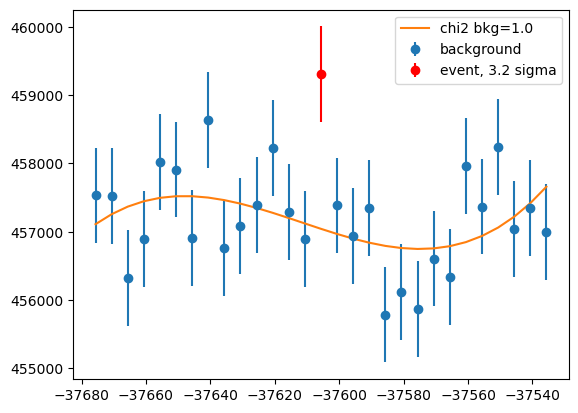

 12%|█▏        | 1065/9220 [00:00<00:03, 2390.51it/s]

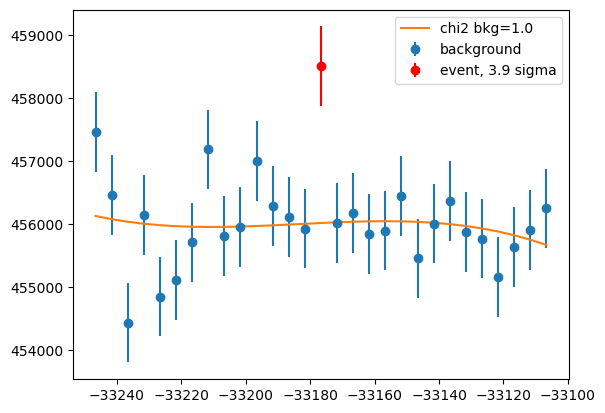

 20%|██        | 1854/9220 [00:00<00:02, 3166.59it/s]

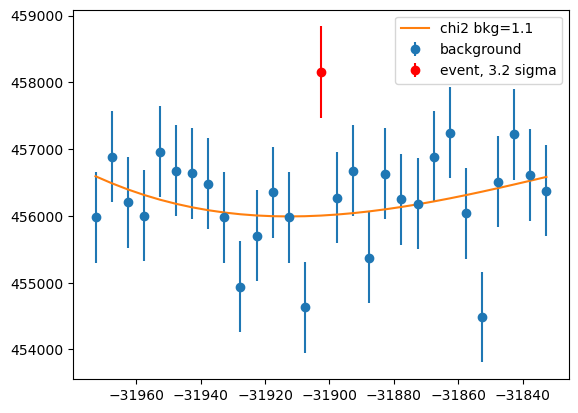

 23%|██▎       | 2155/9220 [00:00<00:02, 2732.03it/s]

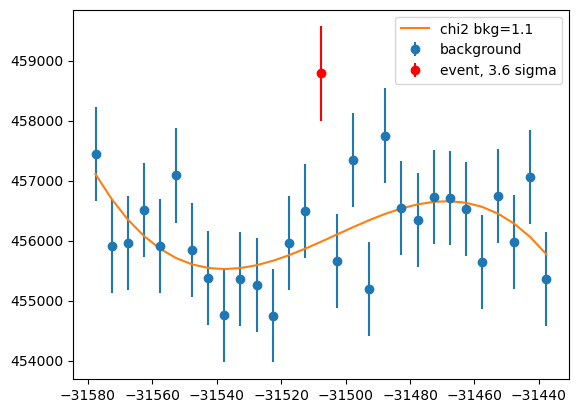

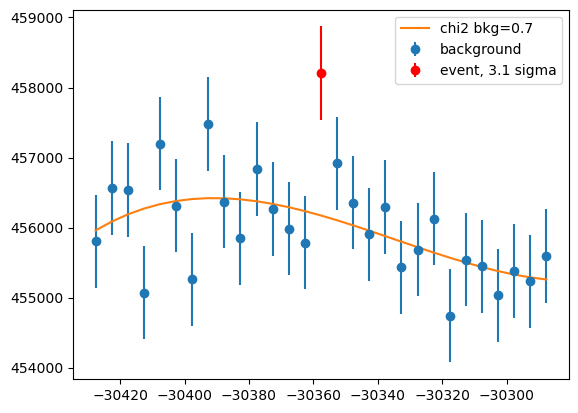

 26%|██▌       | 2417/9220 [00:01<00:03, 1965.79it/s]

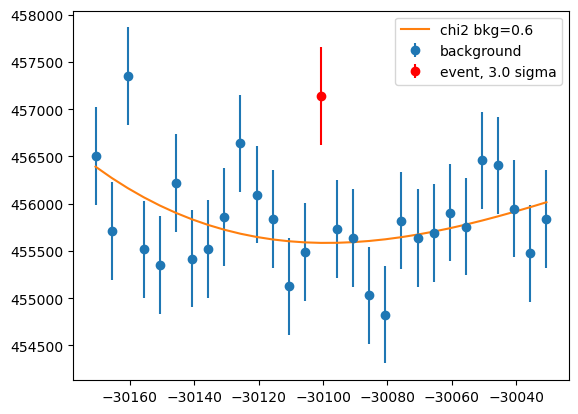

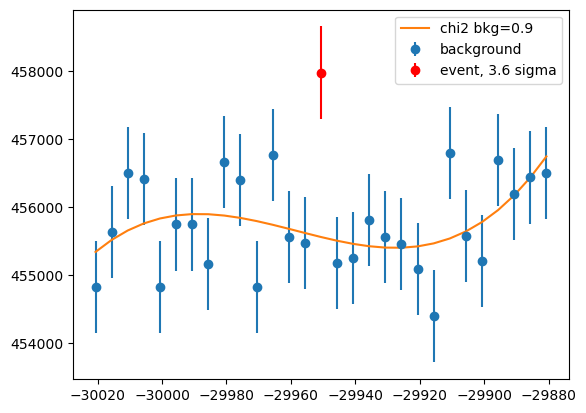

 28%|██▊       | 2625/9220 [00:01<00:04, 1554.16it/s]

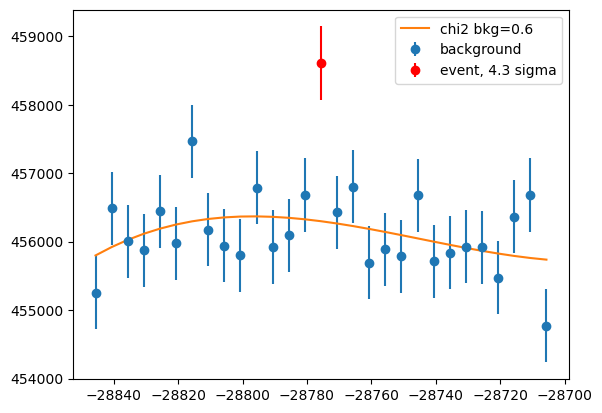

 30%|███       | 2794/9220 [00:01<00:04, 1533.71it/s]

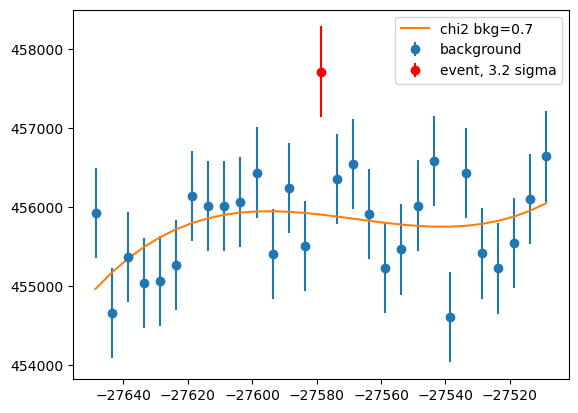

 32%|███▏      | 2972/9220 [00:01<00:03, 1583.82it/s]

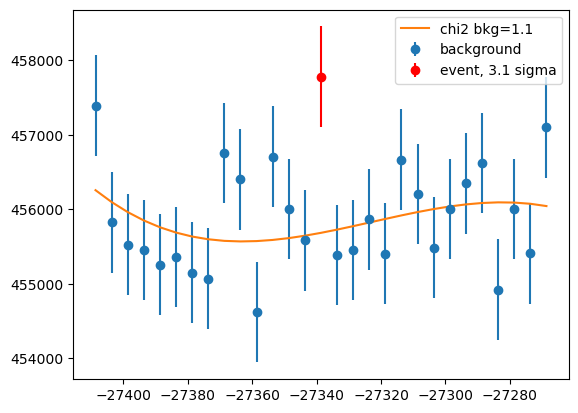

 34%|███▍      | 3139/9220 [00:01<00:04, 1492.65it/s]

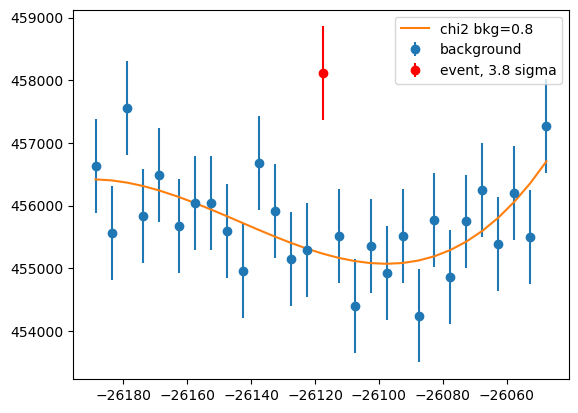

 36%|███▌      | 3293/9220 [00:01<00:04, 1471.41it/s]

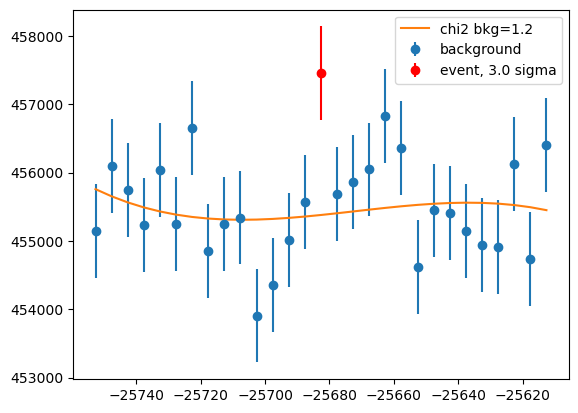

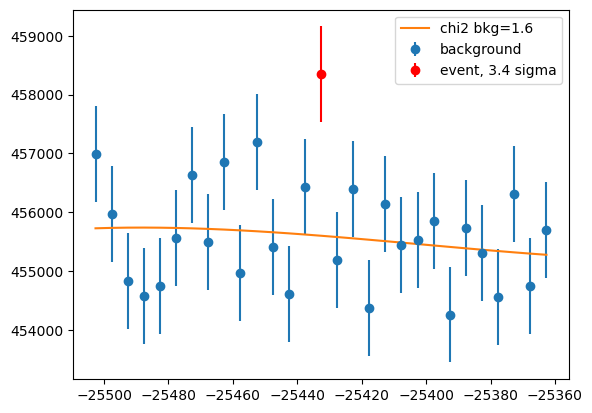

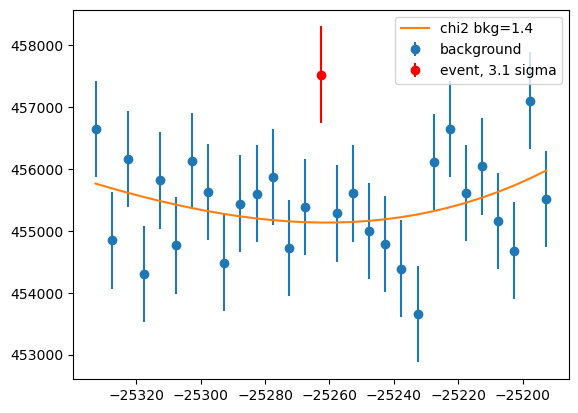

 37%|███▋      | 3443/9220 [00:02<00:06, 873.34it/s] 

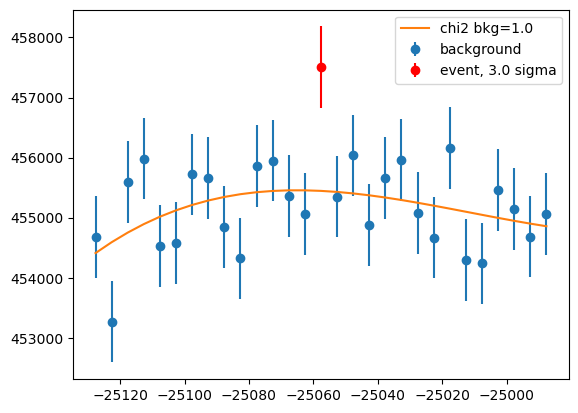

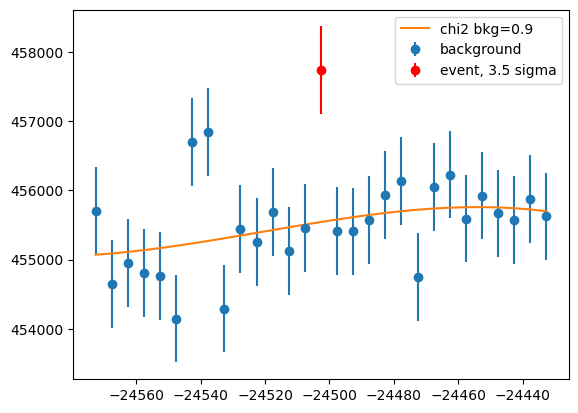

 39%|███▉      | 3587/9220 [00:02<00:06, 848.43it/s]

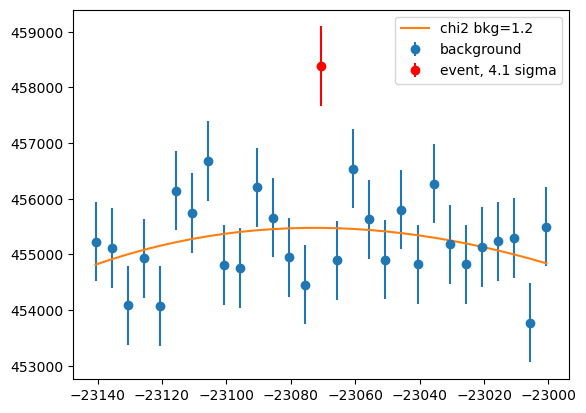

 42%|████▏     | 3873/9220 [00:02<00:04, 1179.78it/s]

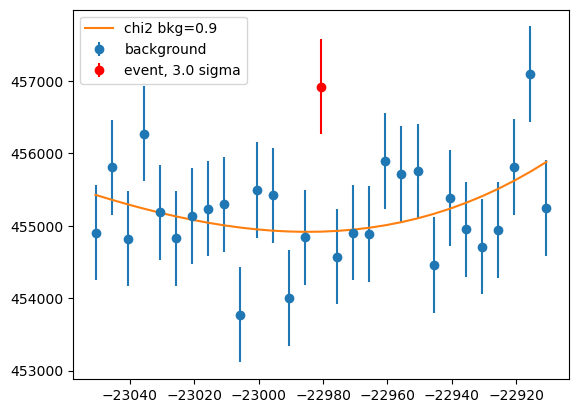

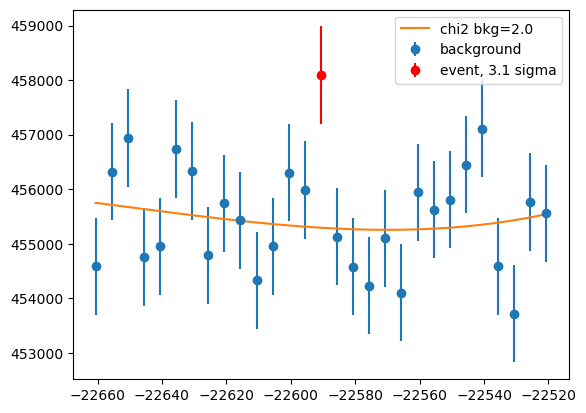

 44%|████▎     | 4025/9220 [00:02<00:05, 999.74it/s] 

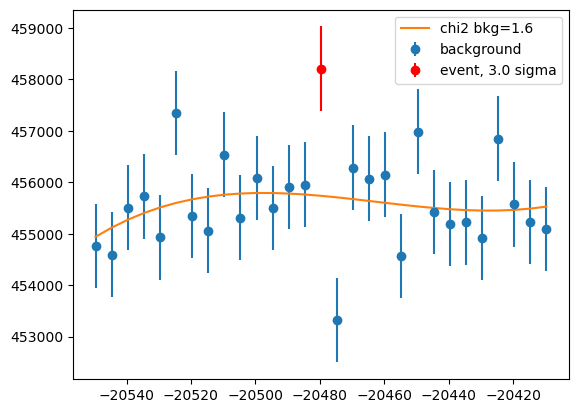

 48%|████▊     | 4391/9220 [00:02<00:03, 1345.12it/s]

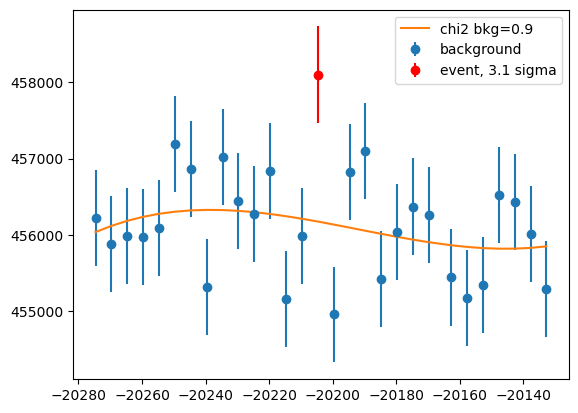

 49%|████▉     | 4549/9220 [00:02<00:03, 1362.46it/s]

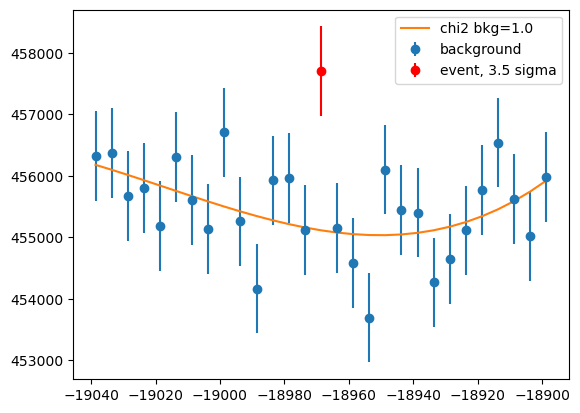

 51%|█████     | 4703/9220 [00:03<00:03, 1346.88it/s]

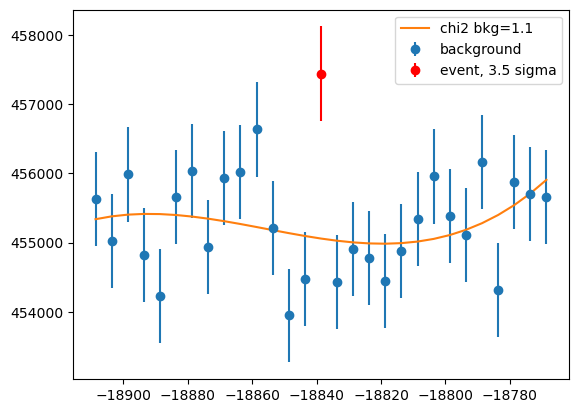

 53%|█████▎    | 4850/9220 [00:03<00:03, 1322.49it/s]

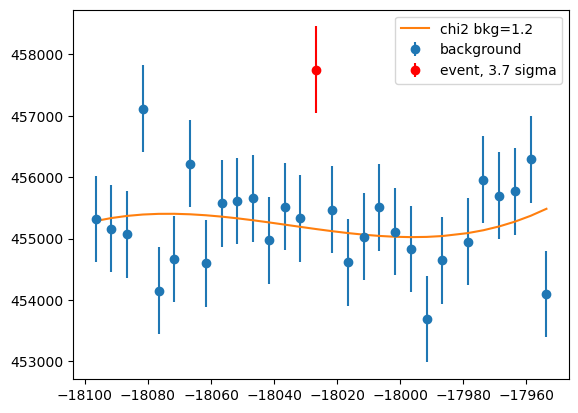

 54%|█████▍    | 4990/9220 [00:03<00:03, 1262.77it/s]

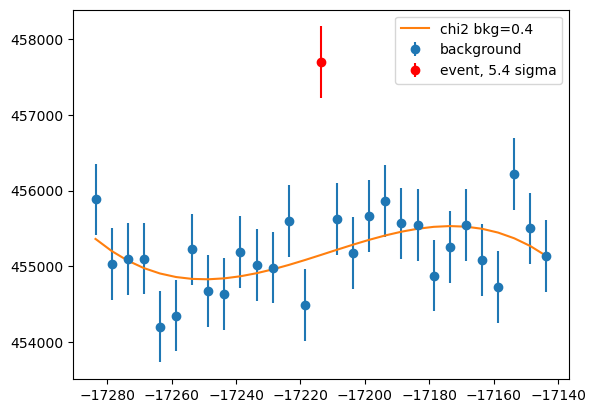

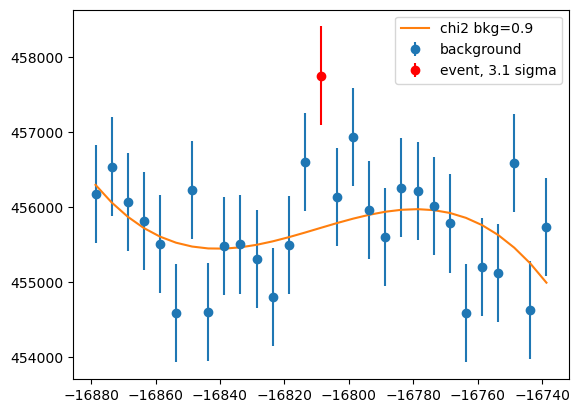

 56%|█████▌    | 5122/9220 [00:03<00:04, 987.33it/s] 

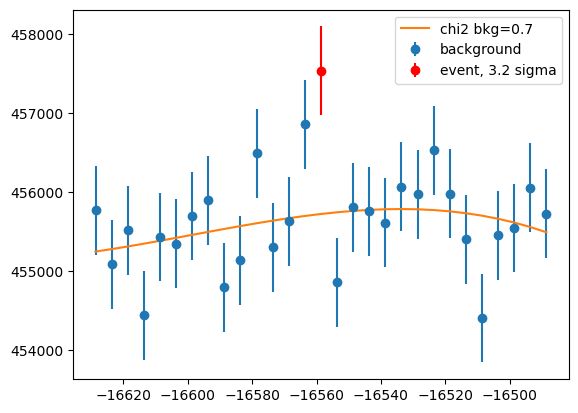

 57%|█████▋    | 5270/9220 [00:03<00:03, 1090.32it/s]

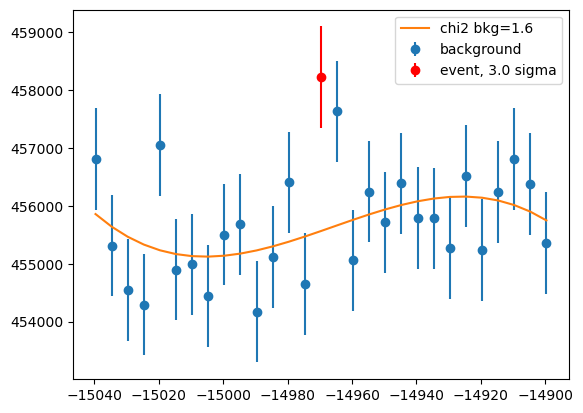

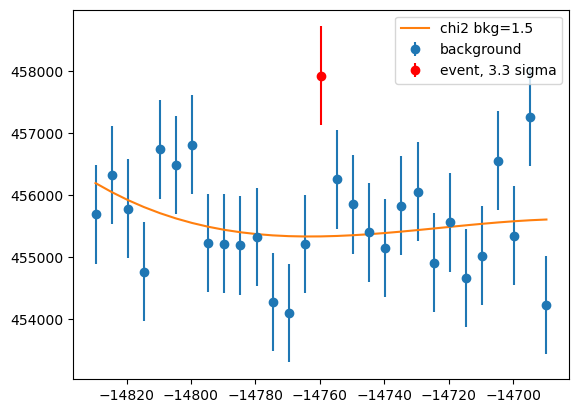

 60%|█████▉    | 5530/9220 [00:03<00:02, 1246.24it/s]

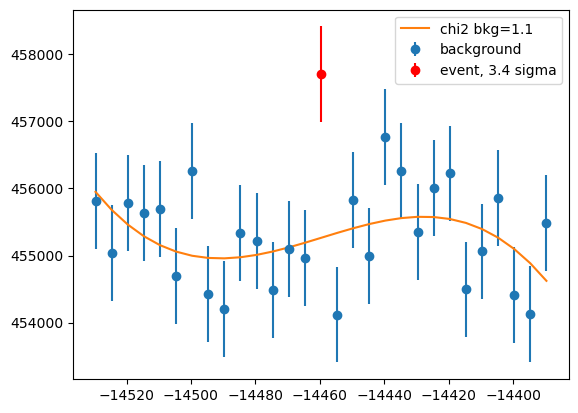

 61%|██████▏   | 5662/9220 [00:03<00:02, 1237.33it/s]

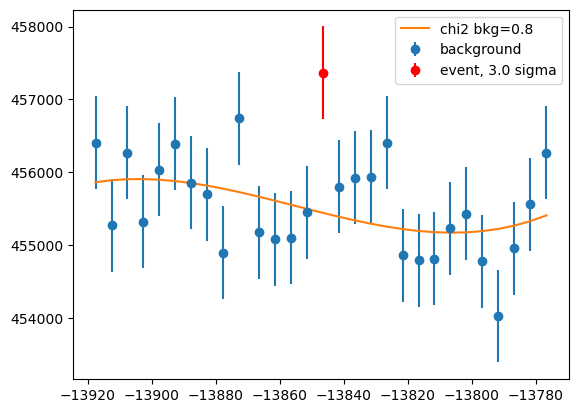

 64%|██████▍   | 5920/9220 [00:03<00:02, 1525.97it/s]

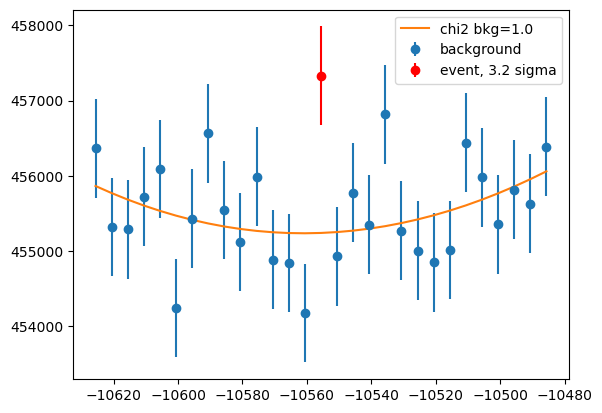

 69%|██████▉   | 6369/9220 [00:04<00:01, 2131.03it/s]

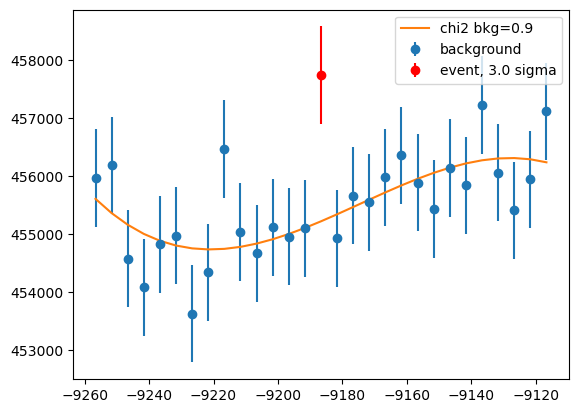

 72%|███████▏  | 6642/9220 [00:04<00:01, 1351.69it/s]

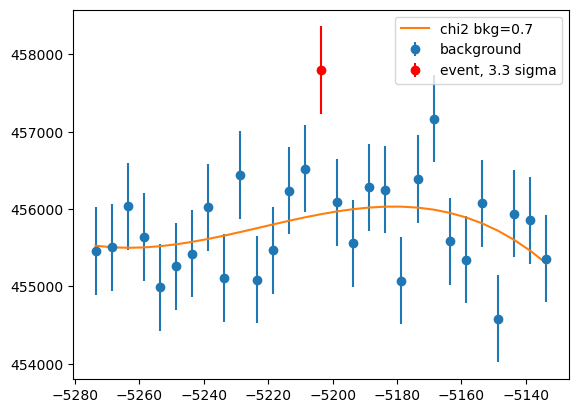

 81%|████████  | 7438/9220 [00:04<00:00, 2166.34it/s]

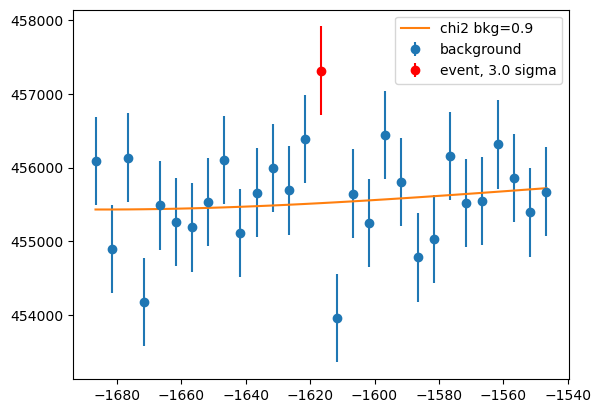

 88%|████████▊ | 8155/9220 [00:04<00:00, 2700.57it/s]

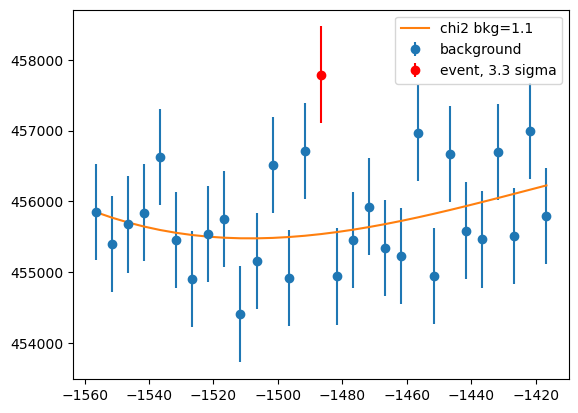

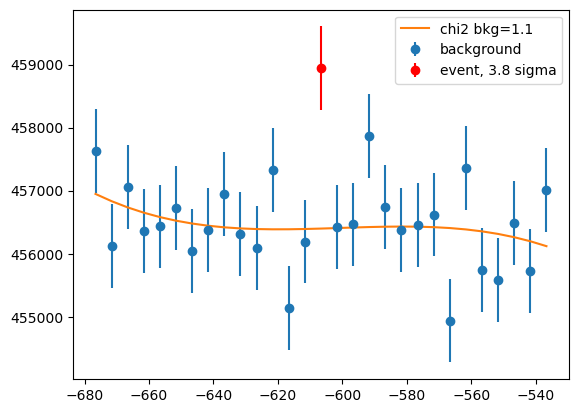

 92%|█████████▏| 8453/9220 [00:05<00:00, 2275.95it/s]

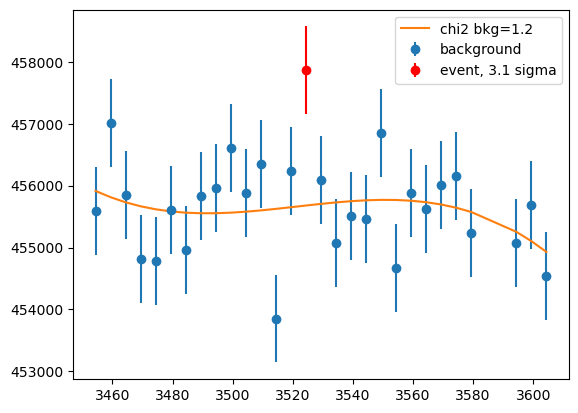

  0%|          | 0/4592 [00:00<?, ?it/s]

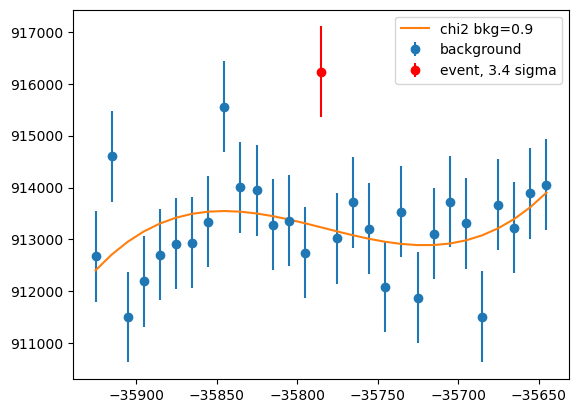

 14%|█▍        | 660/4592 [00:00<00:00, 4738.41it/s]

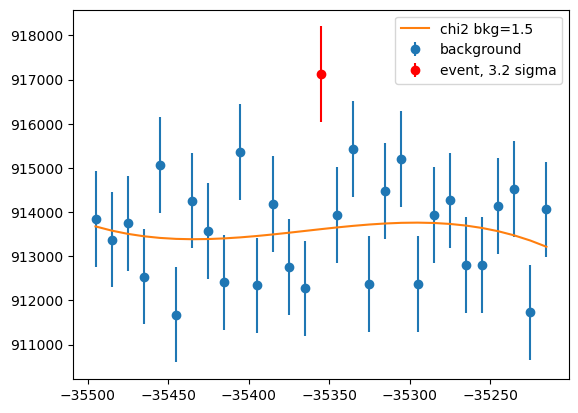

 25%|██▍       | 1134/4592 [00:00<00:00, 4006.96it/s]

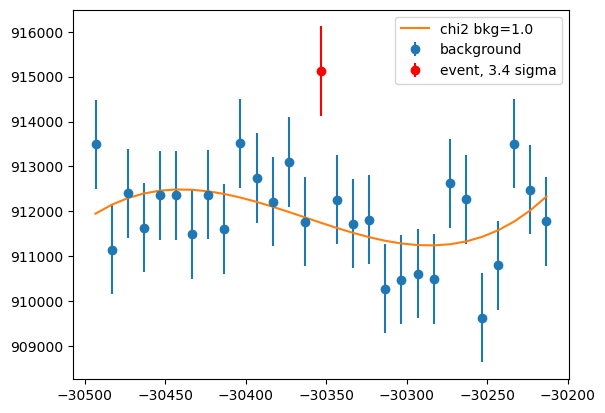

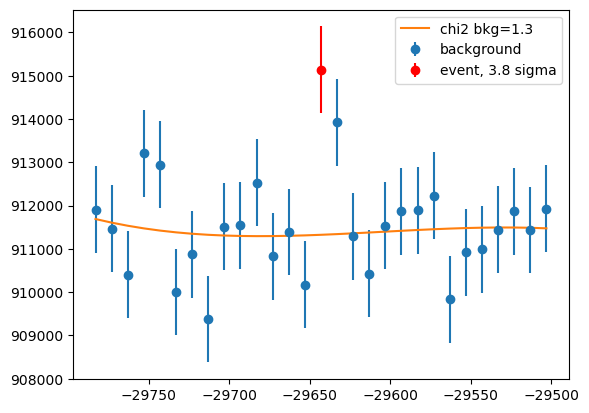

 33%|███▎      | 1534/4592 [00:00<00:01, 2809.03it/s]

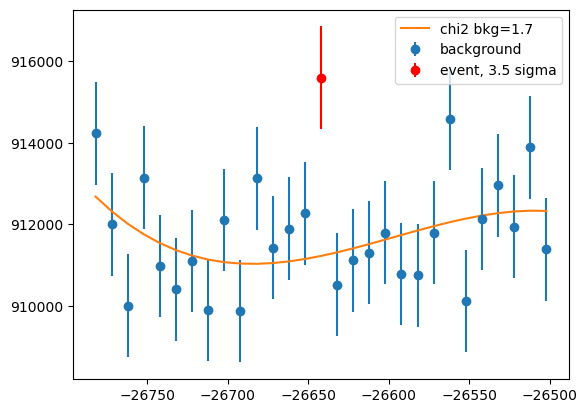

 40%|████      | 1838/4592 [00:00<00:01, 2601.75it/s]

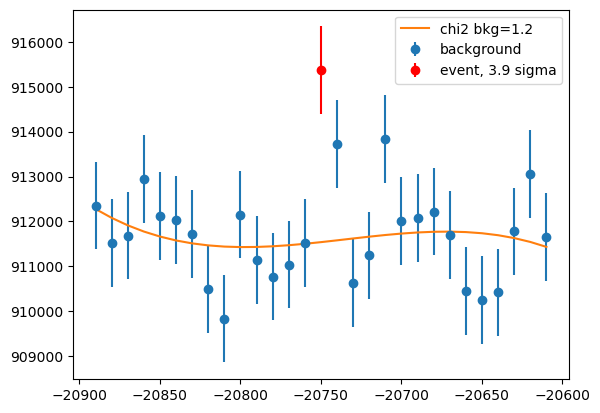

 47%|████▋     | 2163/4592 [00:00<00:01, 2413.04it/s]

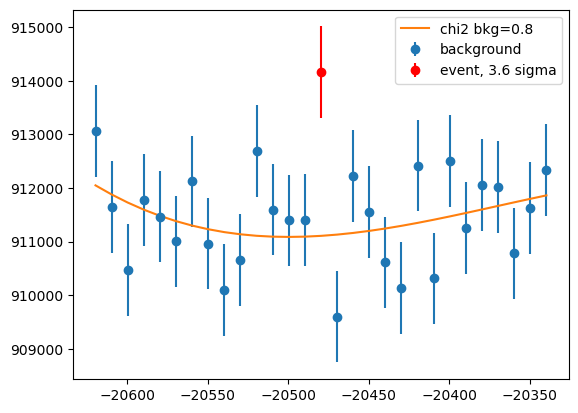

 53%|█████▎    | 2411/4592 [00:00<00:00, 2269.68it/s]

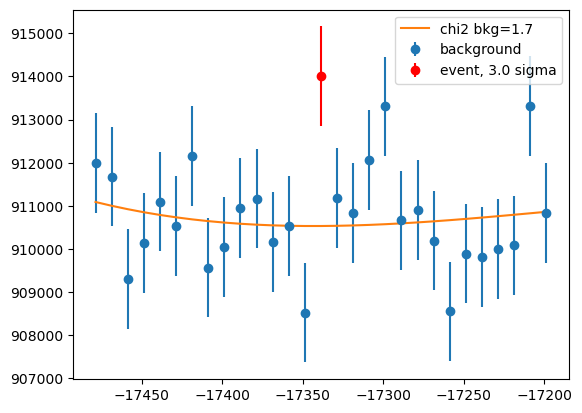

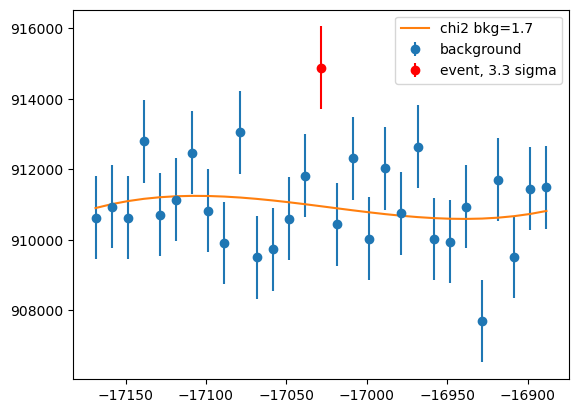

 58%|█████▊    | 2641/4592 [00:01<00:01, 1419.16it/s]

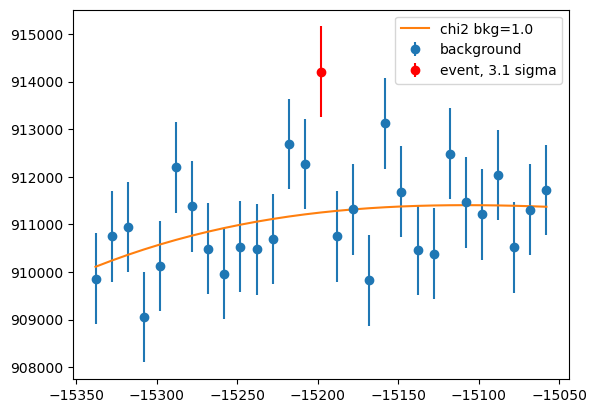

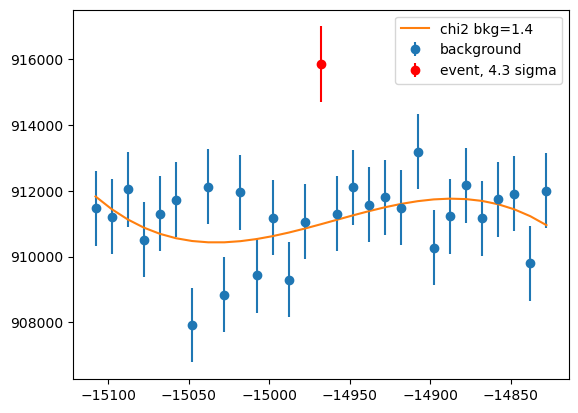

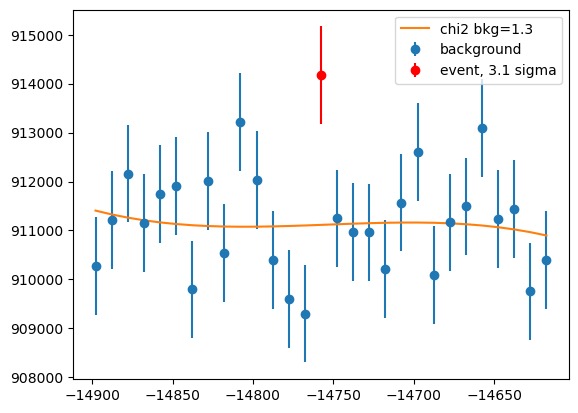

 61%|██████▏   | 2818/4592 [00:01<00:01, 1094.75it/s]

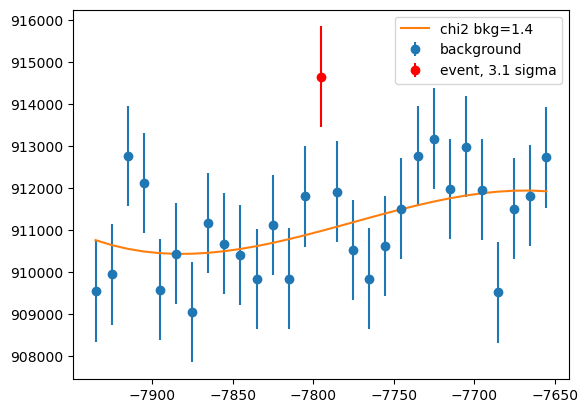

 75%|███████▌  | 3458/4592 [00:01<00:00, 1808.33it/s]

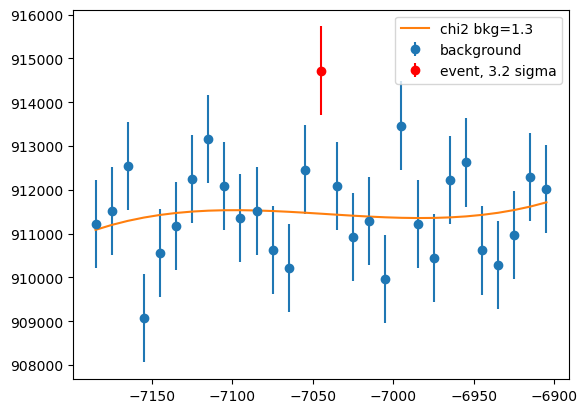

 80%|████████  | 3690/4592 [00:01<00:00, 1849.88it/s]

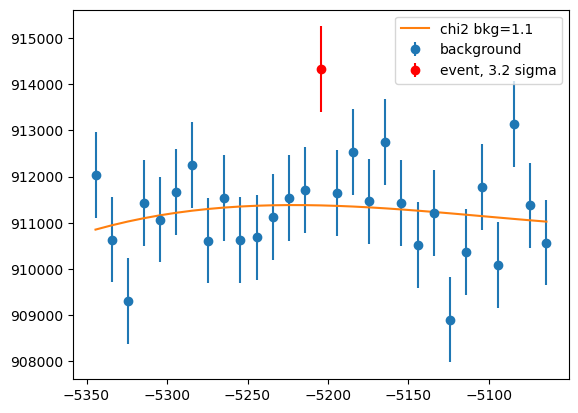

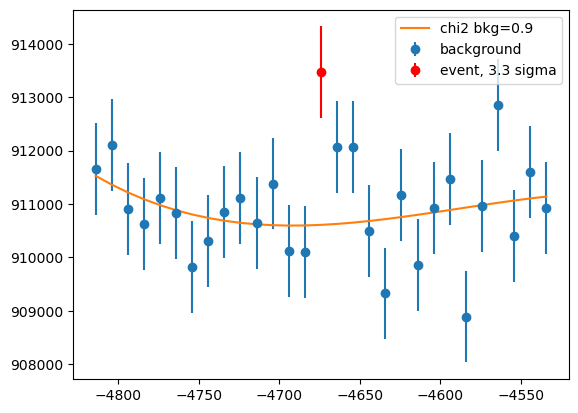

 85%|████████▌ | 3913/4592 [00:01<00:00, 1660.22it/s]

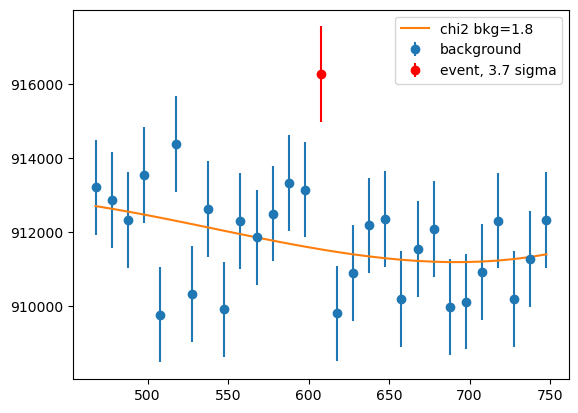

  0%|          | 0/3062 [00:00<?, ?it/s]

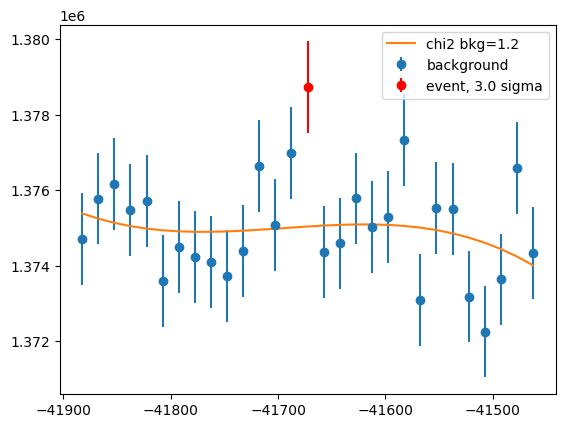

  1%|▏         | 43/3062 [00:00<00:08, 352.10it/s]

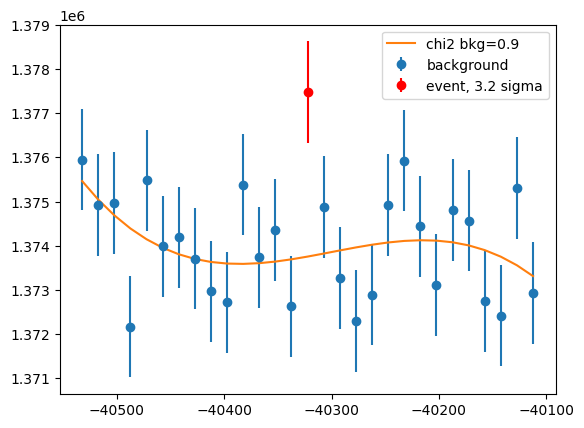

  4%|▍         | 133/3062 [00:00<00:06, 472.56it/s]

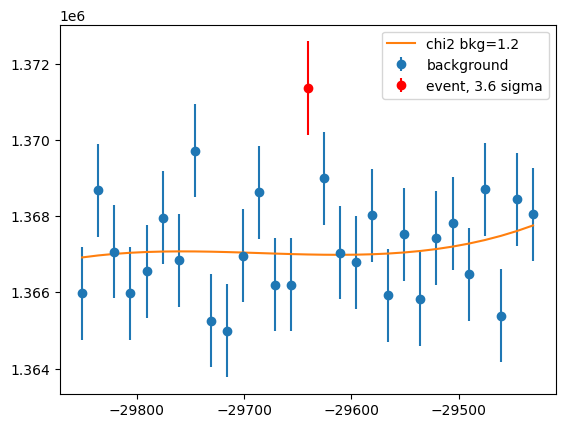

 28%|██▊       | 845/3062 [00:00<00:00, 2382.45it/s]

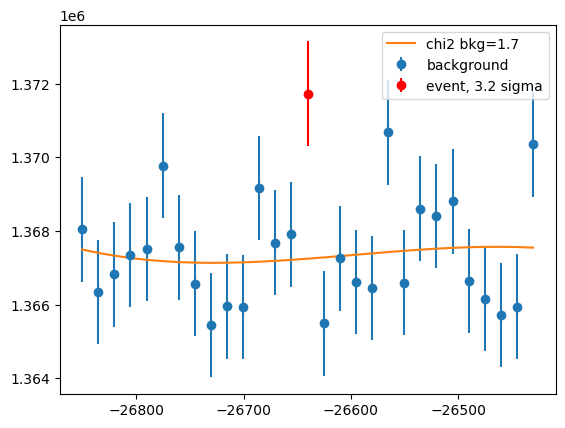

 35%|███▌      | 1079/3062 [00:00<00:00, 2240.00it/s]

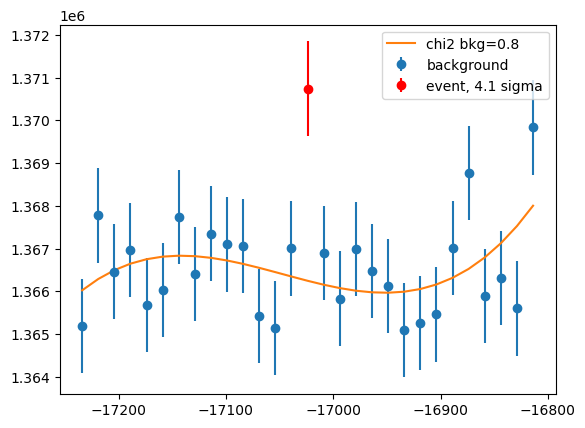

 55%|█████▌    | 1686/3062 [00:00<00:00, 2711.14it/s]

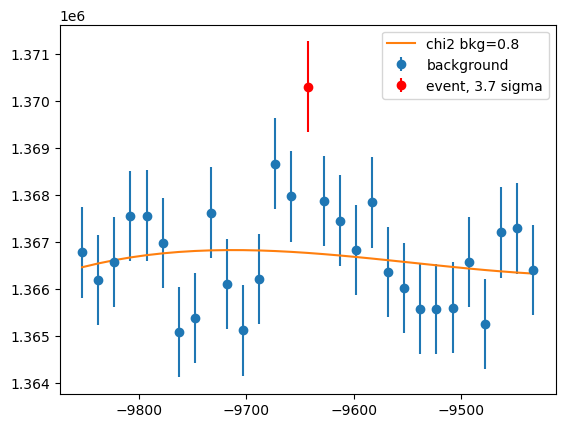

 71%|███████   | 2178/3062 [00:00<00:00, 2454.37it/s]

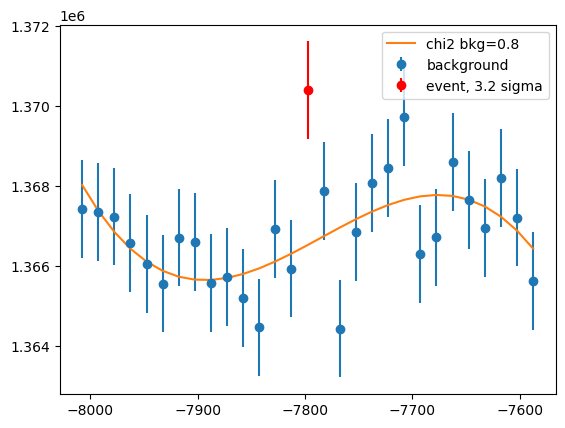

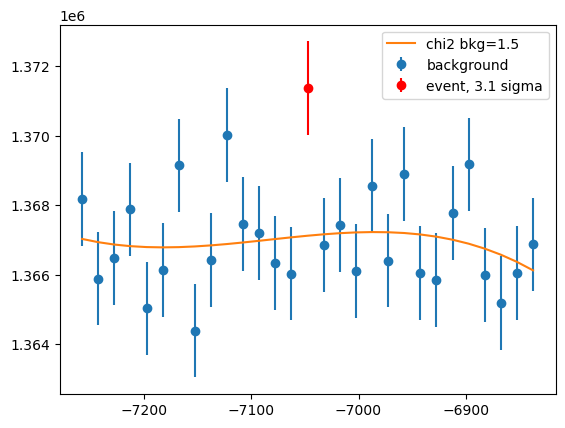

 79%|███████▉  | 2423/3062 [00:01<00:00, 1953.92it/s]

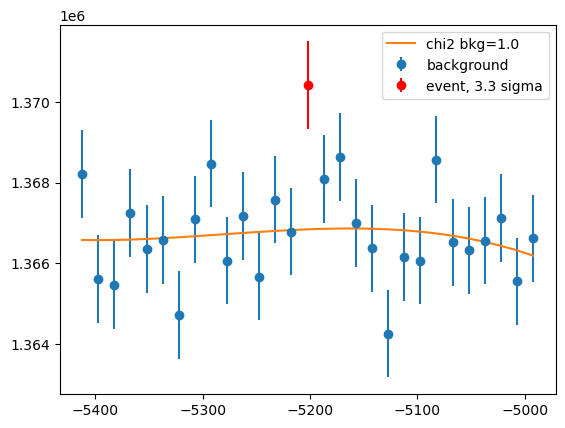

 86%|████████▌ | 2624/3062 [00:01<00:00, 1921.06it/s]

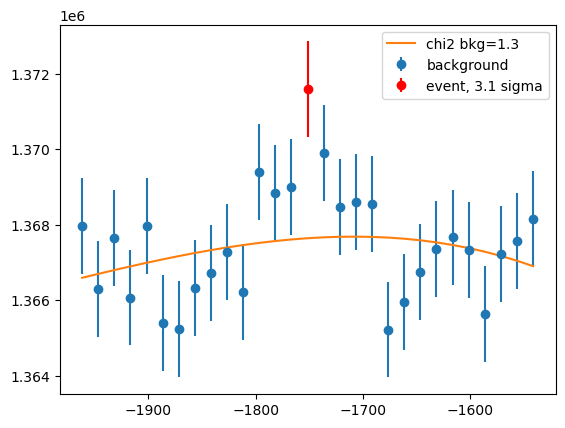

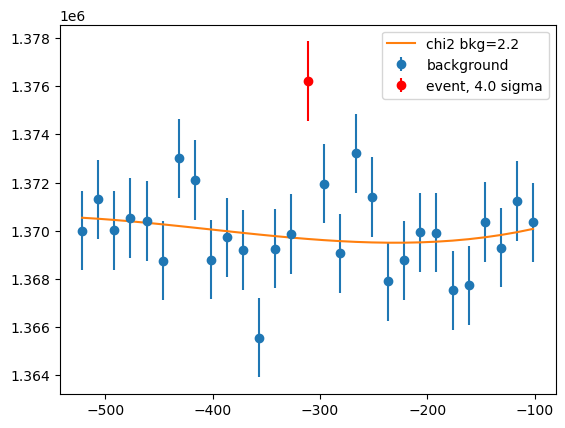

  0%|          | 0/2285 [00:00<?, ?it/s]

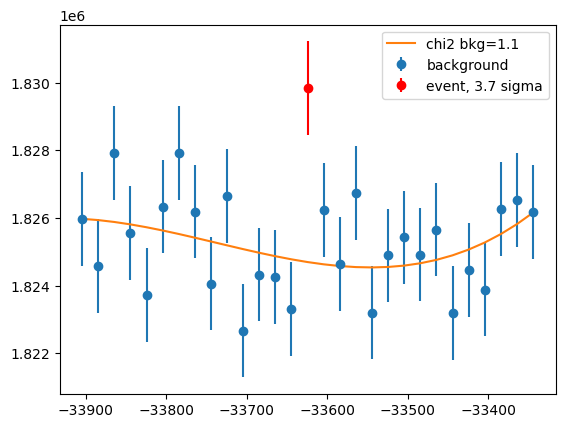

 19%|█▉        | 431/2285 [00:00<00:00, 3639.99it/s]

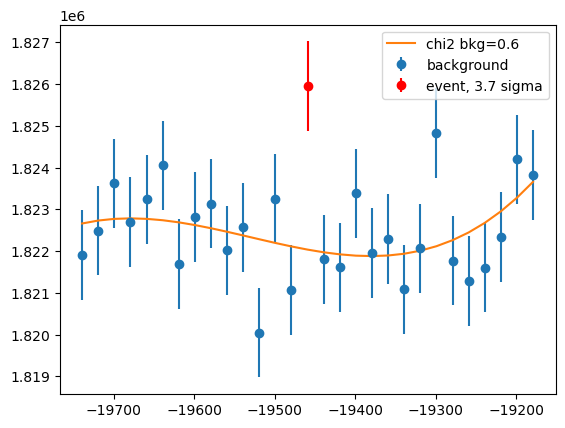

 50%|████▉     | 1139/2285 [00:00<00:00, 4263.53it/s]

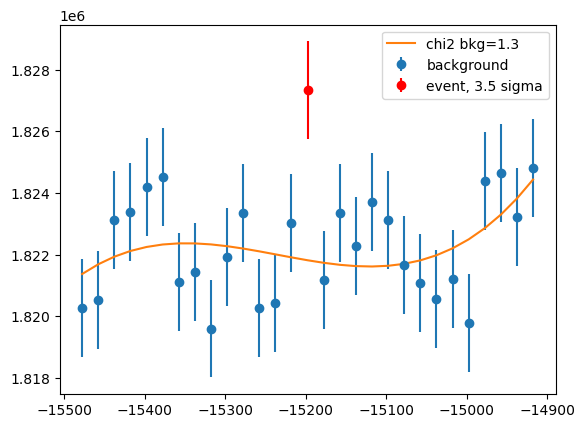

 68%|██████▊   | 1560/2285 [00:00<00:00, 3882.85it/s]

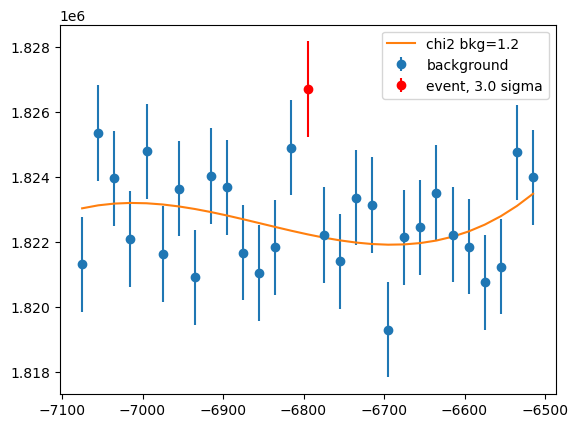

 85%|████████▌ | 1943/2285 [00:00<00:00, 3188.06it/s]

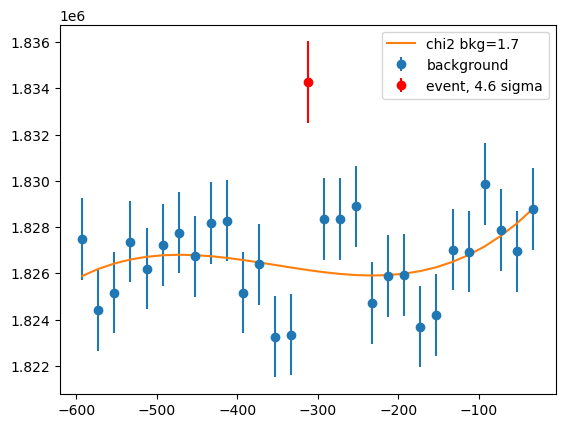

  0%|          | 0/1823 [00:00<?, ?it/s]

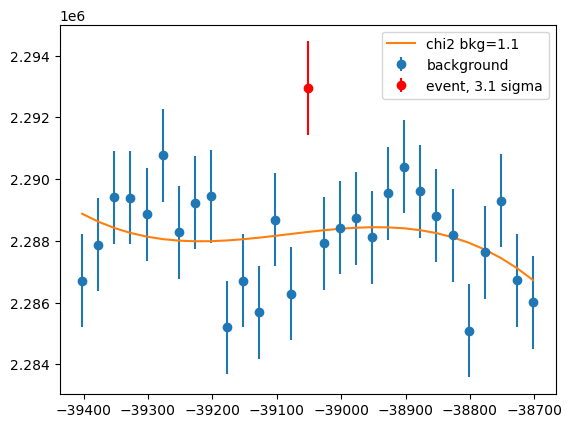

  7%|▋         | 134/1823 [00:00<00:01, 1330.97it/s]

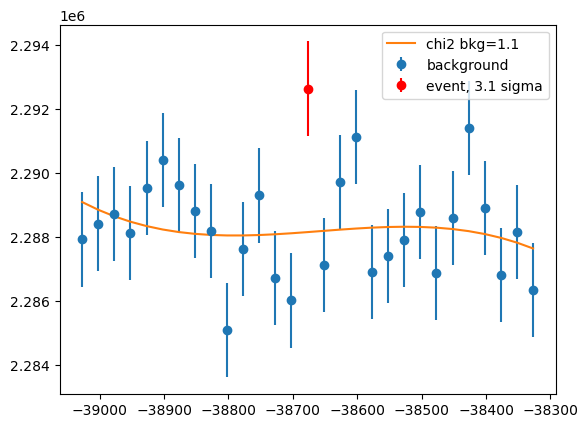

 15%|█▍        | 268/1823 [00:00<00:01, 1078.70it/s]

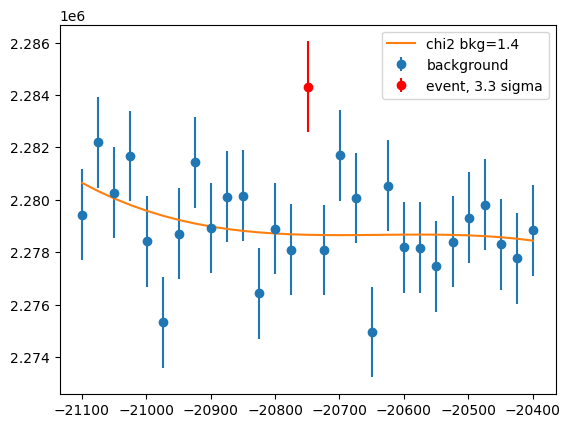

 47%|████▋     | 857/1823 [00:00<00:00, 2107.43it/s]

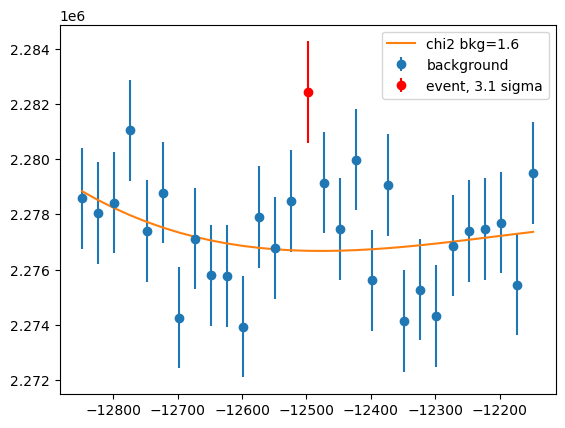

 65%|██████▌   | 1187/1823 [00:00<00:00, 1992.59it/s]

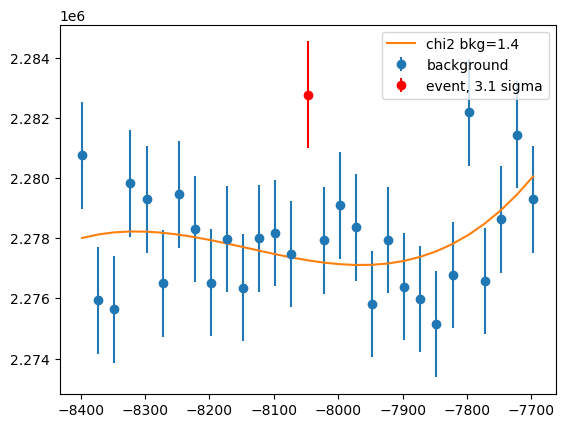

 75%|███████▌  | 1375/1823 [00:00<00:00, 1951.80it/s]

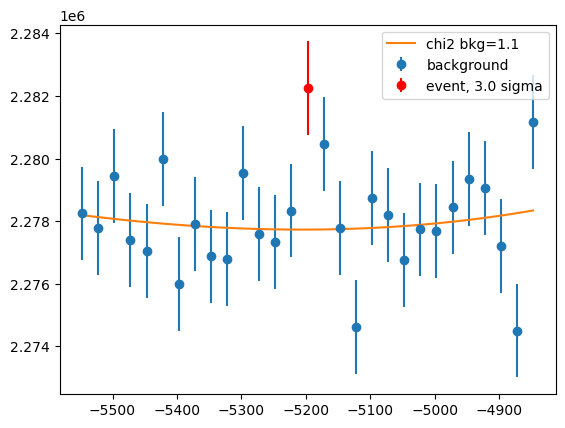

 86%|████████▌ | 1561/1823 [00:00<00:00, 1915.04it/s]

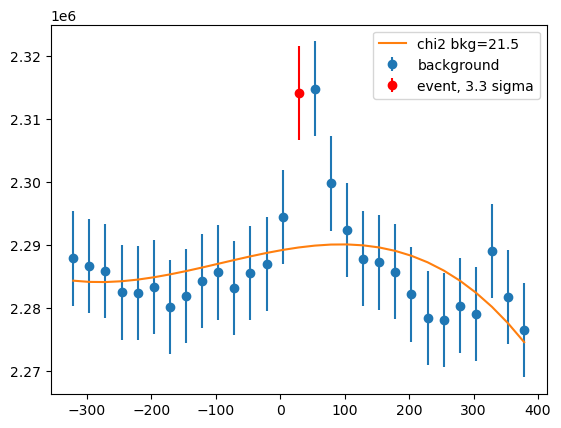

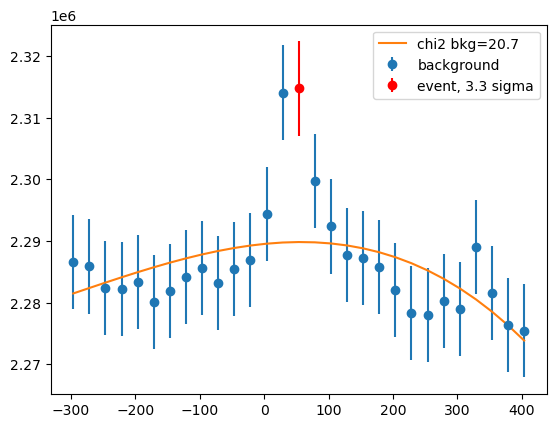

 62%|██████▏   | 943/1515 [00:00<00:00, 9380.20it/s]

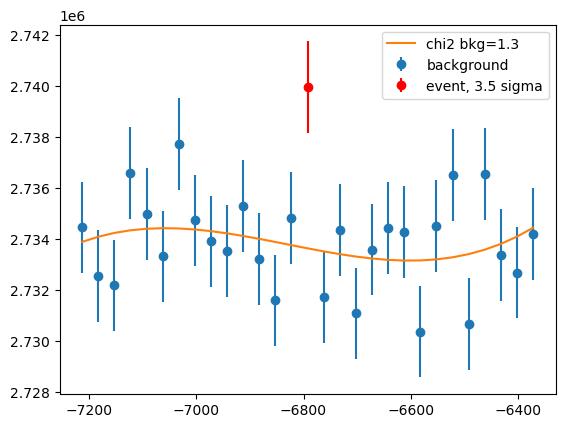

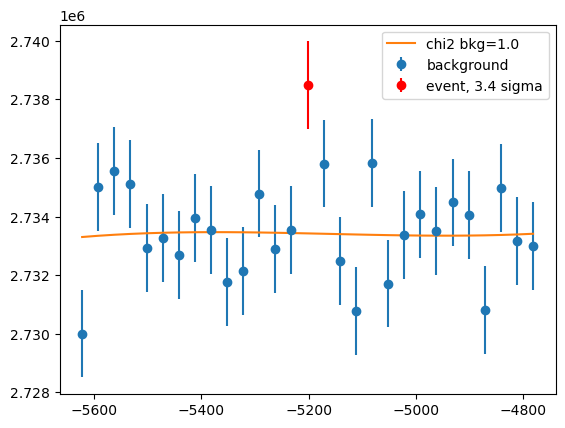

  0%|          | 0/1292 [00:00<?, ?it/s]

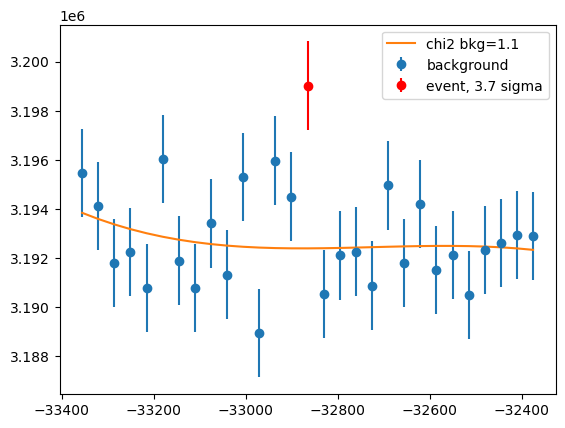

 23%|██▎       | 297/1292 [00:00<00:00, 2772.43it/s]

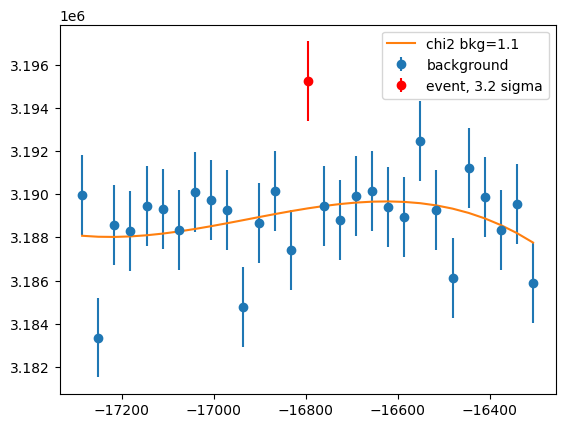

 56%|█████▌    | 721/1292 [00:00<00:00, 3054.61it/s]

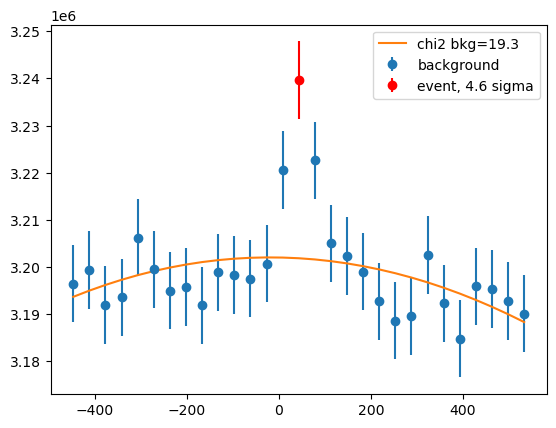

  0%|          | 0/1125 [00:00<?, ?it/s]

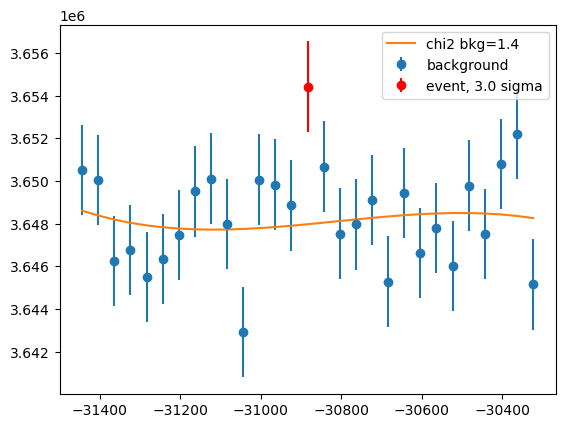

 25%|██▍       | 277/1125 [00:00<00:00, 2764.51it/s]

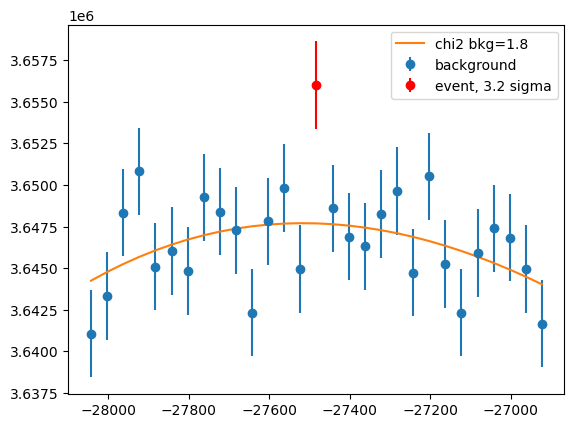

 49%|████▉     | 554/1125 [00:00<00:00, 2376.65it/s]

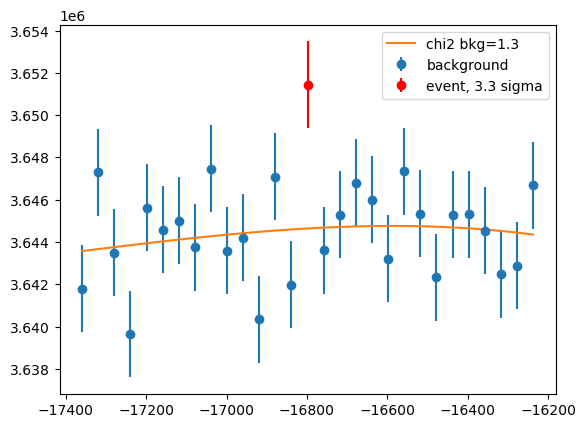

 71%|███████   | 796/1125 [00:00<00:00, 1433.58it/s]

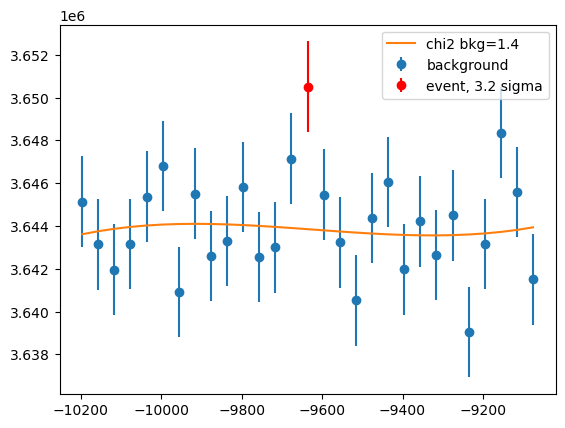

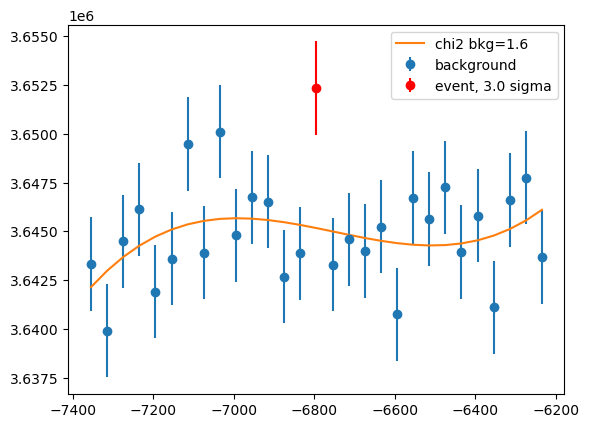

 86%|████████▌ | 970/1125 [00:00<00:00, 1228.35it/s]

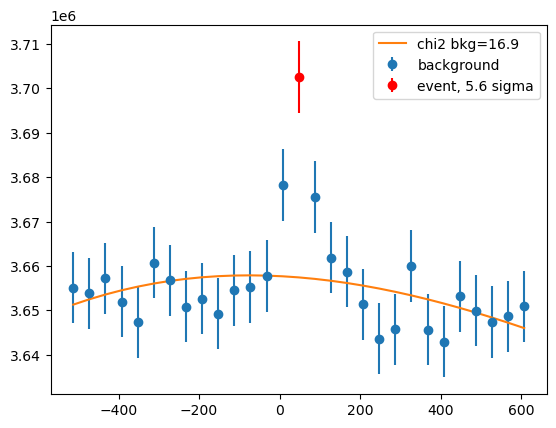

  0%|          | 0/1004 [00:00<?, ?it/s]

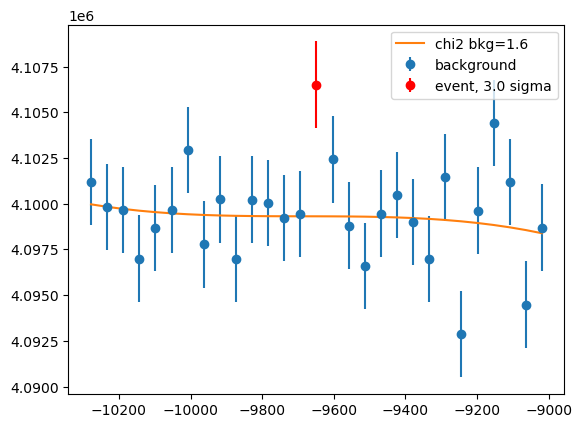

 71%|███████▏  | 717/1004 [00:00<00:00, 4019.45it/s]

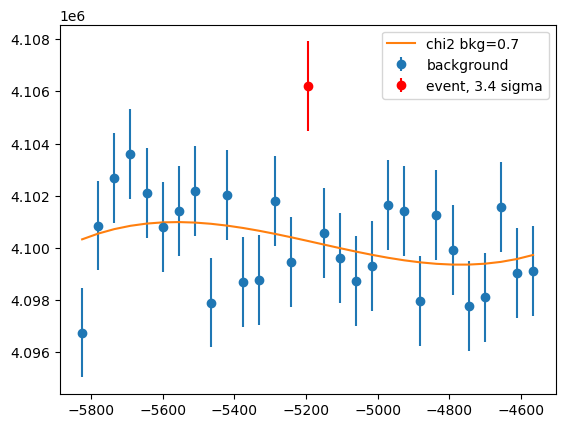

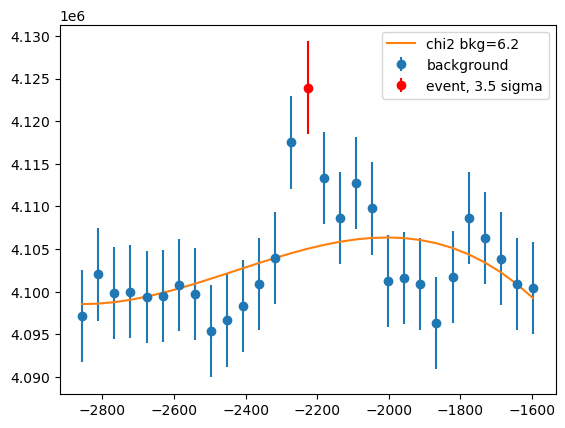

  0%|          | 0/894 [00:00<?, ?it/s]

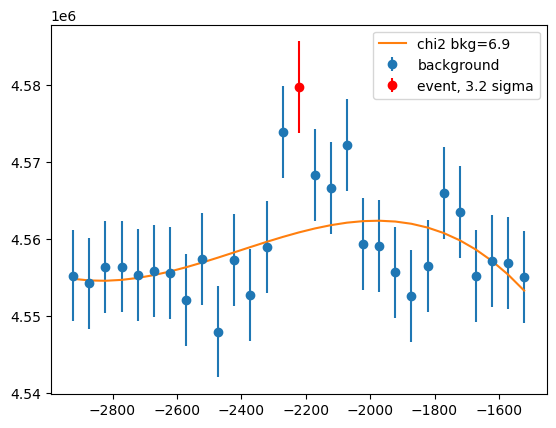

  0%|          | 0/810 [00:00<?, ?it/s]

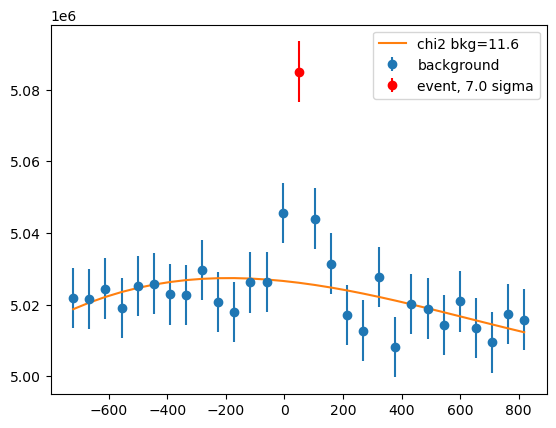

  0%|          | 0/744 [00:00<?, ?it/s]

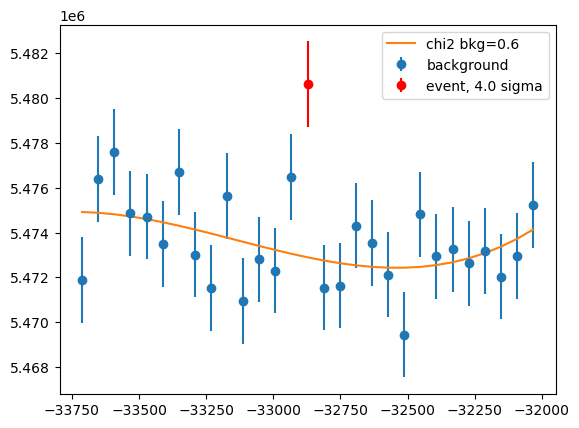

 20%|█▉        | 147/744 [00:00<00:00, 1244.32it/s]

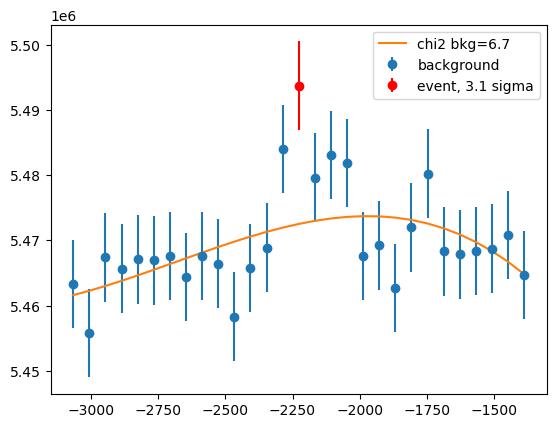

 88%|████████▊ | 658/744 [00:00<00:00, 2374.06it/s]

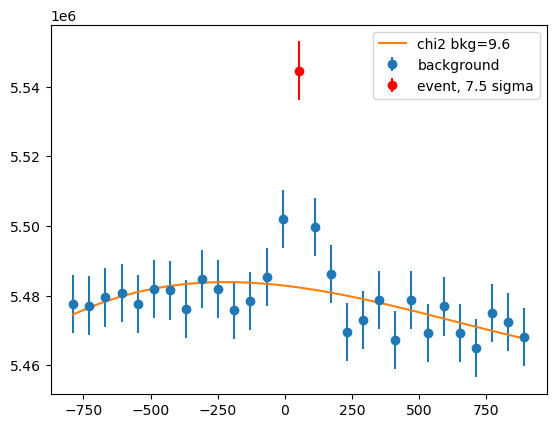

  0%|          | 0/685 [00:00<?, ?it/s]

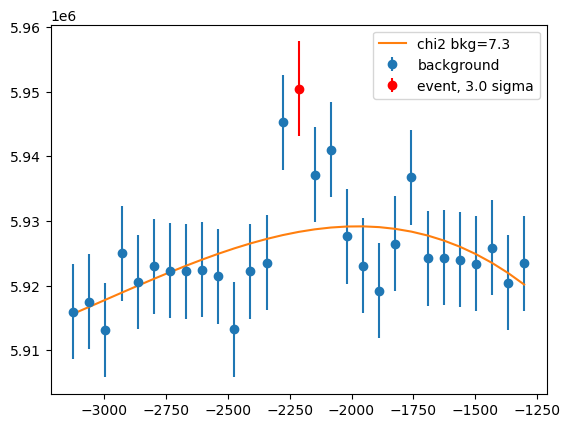

 88%|████████▊ | 606/685 [00:00<00:00, 4288.34it/s]

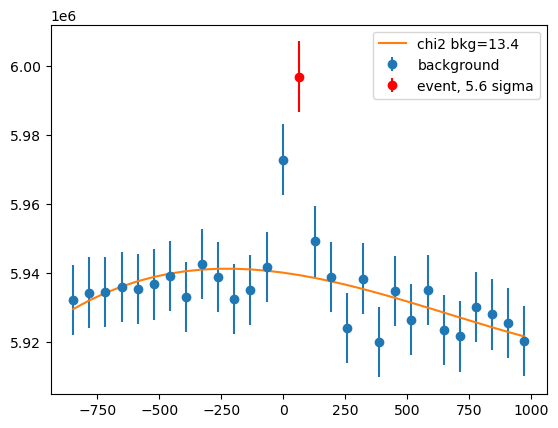

  0%|          | 0/629 [00:00<?, ?it/s]

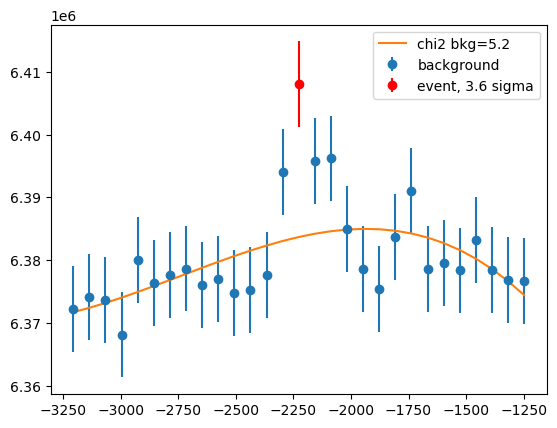

 89%|████████▉ | 562/629 [00:00<00:00, 4498.21it/s]

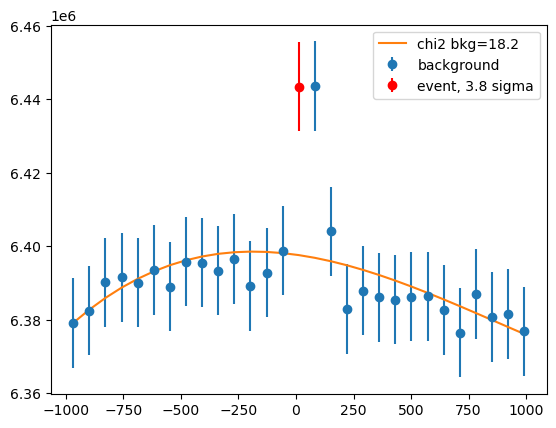

  0%|          | 0/588 [00:00<?, ?it/s]

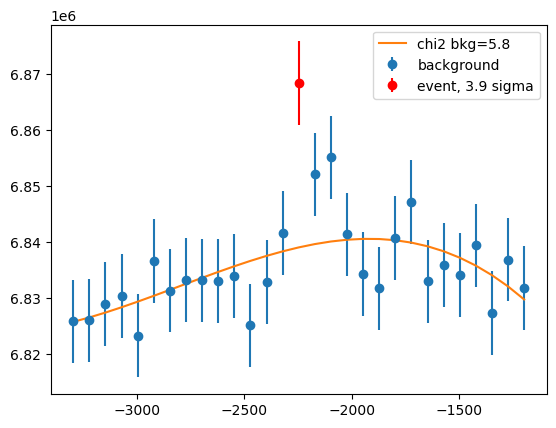

  0%|          | 0/551 [00:00<?, ?it/s]

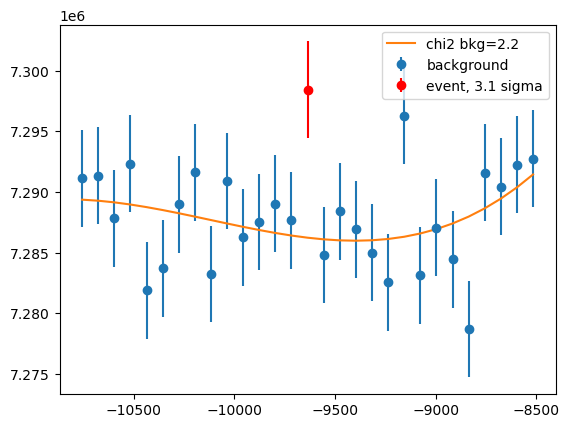

  0%|          | 0/517 [00:00<?, ?it/s]

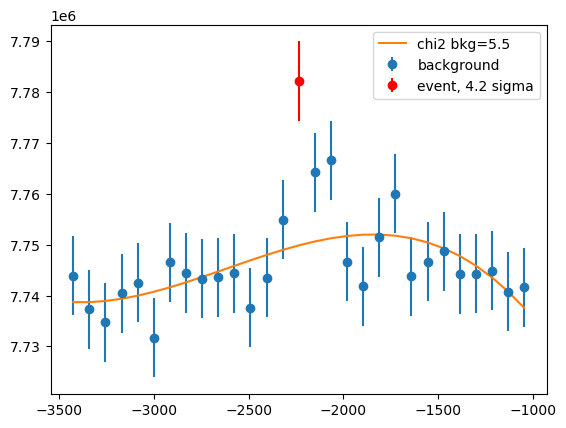

  0%|          | 0/484 [00:00<?, ?it/s]

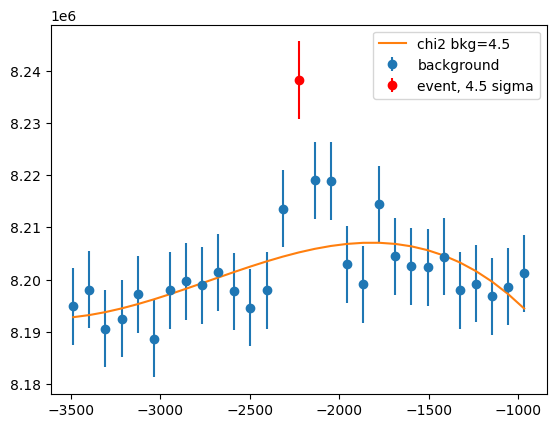

  0%|          | 0/460 [00:00<?, ?it/s]

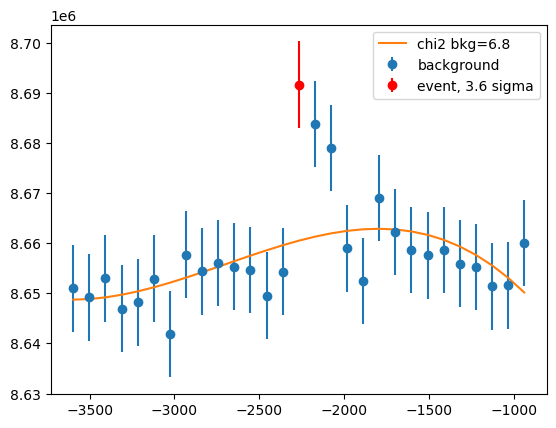

  0%|          | 0/412 [00:00<?, ?it/s]

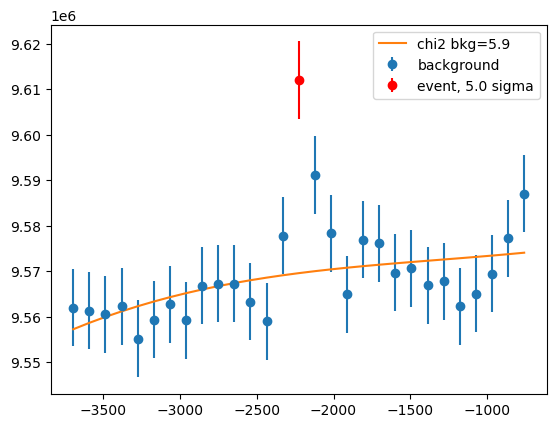

  0%|          | 0/388 [00:00<?, ?it/s]

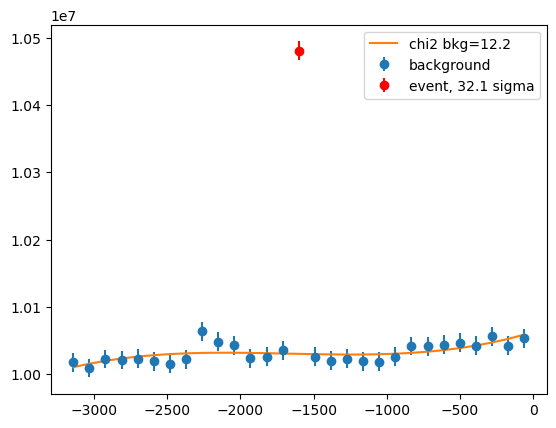

  0%|          | 0/371 [00:00<?, ?it/s]

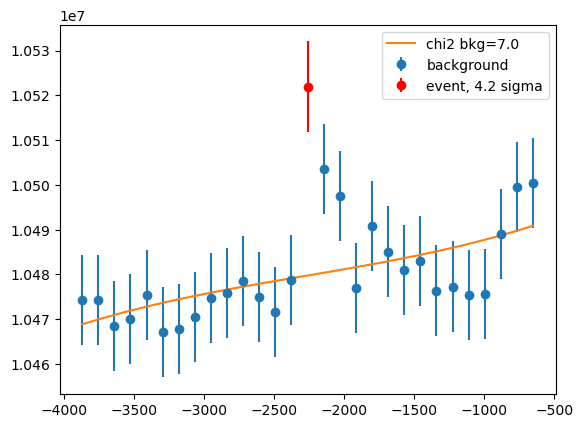

  0%|          | 0/357 [00:00<?, ?it/s]

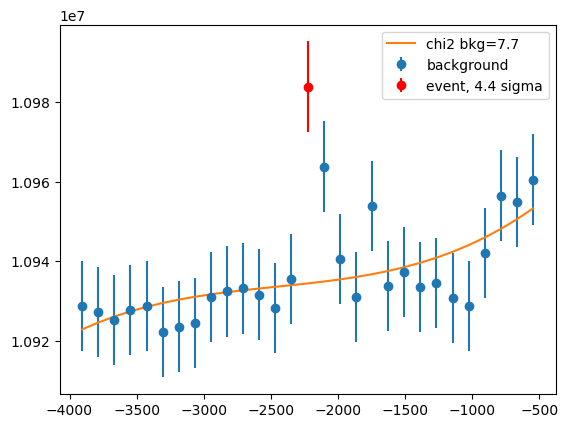

100%|██████████| 357/357 [00:00<00:00, 3236.13it/s]


In [5]:
events = []
for scale,params in ztf_search_conditions.items():
    # filter data
    if scale != 5:
        ACS_lc.rebin(scale)
    else:
        ACS_lc.rebin()
    times,signal = filter_missing_data_and_flares(ACS_lc.times, ACS_lc.signal)

    gap = np.median(times[1:] - times[:-1])

    # no need in using LightCurve class, data is already rebined and filtered
    for i in tqdm(range(times.shape[0]-params['n_bins']-1)):
        if (times[i + params['n_bins']] - times[i]) < gap * (params['n_bins']+3):
            utc_time,significance,chi_2 = process_time_window(times[i:i + params['n_bins']], 
                                                              signal[i:i + params['n_bins']], 
                                                              int(params['n_bins']//2), 
                                                              params['sigma_threshold'],
                                                              plot=True)
            if utc_time is not None:
                events.append({'time':utc_time, 'significance':significance, 'chi_2':chi_2, 'scale':scale})

In [3]:
hdul = fits.open(f'https://heasarc.gsfc.nasa.gov/FTP/fermi/data/gbm/daily/2023/01/22/current/glg_spechist_n9_230122_v00.fit')